# D-Wave の基本：最大カット問題を Braket で使う

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

このチュートリアルでは、Amazon Braket の D-Wave デバイスを使用して、有名な __Maximum-Cut (MaxCut)__ 問題の小さなインスタンスを解決します。 MaxCut 問題は、組合せ最適化で最も有名なNP困難問題の1つです。 頂点セット $V$ とエッジセット $E$ を持つ無向グラフ $G(V, E)$ が与えられた場合、MaxCut 問題は、2つのセット間のエッジの数が最も大きくなるように、 $V$ を2つのセットに分割しようとします。 

この MaxCut 問題の実アプリケーションとしては、例えばマーケティング目的のクラスタリング問題や、金融のポートフォリオ最適化問題になどが考えられています。

このハンズオンを実行するのに、0.3019ドル（1タスク + 10ショット 0.0019ドル）かかりますので、予めご了承ください。ジョブを複数投げると、その分コストが発生しますのでご利用の際はご注意ください。

免責事項：この例に示されているコードは、[こちら](https://github.com/dwave-examples/maximum-cut) の Github で入手可能な D-Wave チュートリアルから抜粋したものであり、著作権は D-Wave Systems、Inc. にあります。 Apacheライセンスの下でライセンスされています。 下記のスクリプトの目的は、D-Wave の Ocean tool suite を使用する既存のコードを、最小限のコード変更で Amazon Braket で簡単に実行できることを示すことです。

In [2]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [3]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

In [4]:
# session and device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system4")
print('Device:', device)

Device: Device('name': Advantage_system4.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system4)


## 最大カット問題の設定

In [5]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

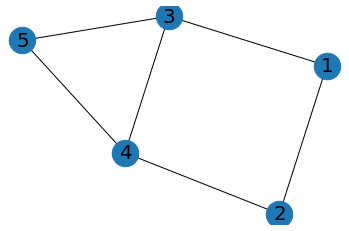

Show Q matrix: defaultdict(<class 'int'>, {(1, 1): -2, (2, 2): -2, (1, 2): 2, (3, 3): -3, (1, 3): 2, (4, 4): -3, (2, 4): 2, (3, 4): 2, (5, 5): -2, (3, 5): 2, (4, 5): 2})


In [6]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ------ Import necessary packages ----
from collections import defaultdict

# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite

# ------- Set up our graph -------

# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

# plot graph
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for u, v in G.edges:
    Q[(u,u)]+= -1
    Q[(v,v)]+= -1
    Q[(u,v)]+= 2

# print Q matrix
print('Show Q matrix:', Q)

## 最大カット問題をD-Wave 2000 で解く

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
      [2, 3, 5]         [1, 4]     -5.0             5       
         [2, 3]      [1, 4, 5]     -5.0             5       
         [1, 4]      [2, 3, 5]     -5.0             5       
      [1, 4, 5]         [2, 3]     -5.0             5       

Your plot is saved to maxcut_plot.png


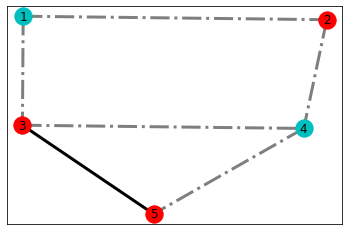

In [7]:
# ------- Run the QUBO problem on the QPU -------
# Set up QPU parameters
chainstrength = 8
numruns = 10

# Run the QUBO on the Braket solver from your config file
# set sampler
sampler = BraketDWaveSampler(device_arn='arn:aws:braket:::device/qpu/d-wave/Advantage_system4')
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
energies = iter(response.data())

# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for line in response:
    S0 = [k for k,v in line.items() if v == 0]
    S1 = [k for k,v in line.items() if v == 1]
    E = next(energies).energy
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.lowest().first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

filename = "maxcut_plot.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))

__DISCUSSION__：このトイプロブレムの最適なカットサイズは5です。上記の破線で表示されているように、異なる色のノードを接続するすべてのエッジについて、ポイントをスコアリングします（つまり、このエッジをカットします）。 ここでは最大で5つのエッジをカットできます。 このおもちゃの例では、ノード5に優先する色がないため、明らかな$ Z_ {2} $対称性（つまり、2つのサブセットの色の選択は任意）を除いて、複数の最適な縮退解が見つかります。この問題は同等です。 フラストレーションの存在下で、反強磁性基底状態を見つけること（ノード3-4-5のサブグラフにここに存在するように）。

---
## APPENDIX

Original MaxCut example from here: https://github.com/dwave-examples/maximum-cut

In [8]:
# # Copyright 2019 D-Wave Systems, Inc.
# #
# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at
# #
# #     http://www.apache.org/licenses/LICENSE-2.0
# #
# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.

# # ------ Import necessary packages ----
# from collections import defaultdict

# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite
# import networkx as nx

# import matplotlib
# matplotlib.use("agg")
# from matplotlib import pyplot as plt

# # ------- Set up our graph -------

# # Create empty graph
# G = nx.Graph()

# # Add edges to the graph (also adds nodes)
# G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

# # ------- Set up our QUBO dictionary -------

# # Initialize our Q matrix
# Q = defaultdict(int)

# # Update Q matrix for every edge in the graph
# for u, v in G.edges:
#     Q[(u,u)]+= -1
#     Q[(v,v)]+= -1
#     Q[(u,v)]+= 2

# # ------- Run our QUBO on the QPU -------
# # Set up QPU parameters
# chainstrength = 8
# numruns = 10

# # Run the QUBO on the solver from your config file
# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
# response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
# energies = iter(response.data())

# # ------- Print results to user -------
# print('-' * 60)
# print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
# print('-' * 60)
# for line in response:
#     S0 = [k for k,v in line.items() if v == 0]
#     S1 = [k for k,v in line.items() if v == 1]
#     E = next(energies).energy
#     print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# # ------- Display results to user -------
# # Grab best result
# # Note: "best" result is the result with the lowest energy
# # Note2: the look up table (lut) is a dictionary, where the key is the node index
# #   and the value is the set label. For example, lut[5] = 1, indicates that
# #   node 5 is in set 1 (S1).
# lut = response.lowest().first.sample

# # Interpret best result in terms of nodes and edges
# S0 = [node for node in G.nodes if not lut[node]]
# S1 = [node for node in G.nodes if lut[node]]
# cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
# uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# # Display best result
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
# nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
# nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
# nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
# nx.draw_networkx_labels(G, pos)

# filename = "maxcut_plot.png"
# plt.savefig(filename, bbox_inches='tight')
# print("\nYour plot is saved to {}".format(filename))

In [9]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost()} USD")

Task Summary
{'arn:aws:braket:::device/qpu/d-wave/Advantage_system4': {'shots': 10, 'tasks': {'COMPLETED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.3019000000 USD
